# Real-world Data Wrangling

## 1. Gather data

### **1.1.** Problem Statement

 *The City of Vancouver tracks not only every animal that comes into its shelters, but also those that are reported as lost by their owners. While the city does track those that are matched back to their owner, is it possible that an animal still tracked as lost has possibly been accounted for? If so, is it possible to find somewhat reliable means to match animals based on data entered into a report for lost ones?*

### **1.2.** Gather at least two datasets using two different data gathering methods


#### City of Vancouver Animal Control Inventory - Lost and Found

This dataset is information from the City of Vancouver where an owner of an animal has reported them as lost. It also tracks those that were either reported as found or were matched by the shelter back to the owner. 

I chose this dataset because it will address what animals were reported as lost within the city. This does not cover every animal that was lost, however it does provide a large sample size for this metro area.

Further information on the dataset can be found [here](https://opendata.vancouver.ca/explore/dataset/animal-control-inventory-lost-and-found/information).

Type: JSON

Method: This data was gathered by querying the City of Vancouver's database with the standard Opendatasoft API. I am doing it this way because the data is updated daily, and this guarantees that the most up-to-date information will be used.

Dataset variables:

- *breed* - type of animal or breed that fits best.
- *color* - color of the animal's coat/fur.
- *date* - date that the animal was lost
- *name* - the given name of the animal being tracked (if known).
- *sex* - used to label the biological sex of the animal, as well as if they are spayed or neutered (marked with `F/S` or `M/N` accordingly). `X` = unknown
- *state* - the last state of being for the animal, i.e. `matched` or `lost`.

After some poking around, I found out that without a `group by` statement, the server only returns 100 results. By including a `group by` statement for all of the fields, this should theoretically drop duplicate values. I'm also filtering out anything before `1998-10-03`, as this is the earliest `DateImpounded` timestamp in the other dataset that will be used.

In [902]:
import requests
import pandas as pd
import datetime

# "lf" is for *l*ost and *f*ound
lf_api_query = "https://opendata.vancouver.ca/api/explore/v2.1/catalog/datasets/animal-control-inventory-lost-and-found/records?where=date%20%3E%20%221998-10-02%22&group_by=date%2C%20breed%2C%20color%2C%20name%2C%20sex%2C%20state&order_by=date&limit=-1"
lf_data = requests.get(lf_api_query)
lf_data.raise_for_status()

In [903]:
lf_json = lf_data.json()

print(lf_json.keys())
print(lf_json['total_count'])

lf_json['results'][0:3]
print(type(lf_json['results']))     # all elements
print(type(lf_json['results'][0]))  # individual element

dict_keys(['total_count', 'results'])
17872
<class 'list'>
<class 'dict'>


Based on our mild digging above, we would want to load specifically the data in the `results` key as a Pandas DataFrame, since `results` is simply a `list` of `dict`'s, which Pandas.DataFrame's constructor can handle.

In [904]:
lf_df = pd.DataFrame(lf_json['results'])

#### City of Vancouver Animal Control Inventory - Register

This dataset is a "general record of each animal that has come into the custody" the City of Vancouver's animal control service.

I chose this dataset to have a record to compare all of the lost and found animals to in the event an animal is reported as lost and the City of Vancouver happens to have them, or someone very much like them, already processed into their database.

Like with the lost and found dataset, this data is updated daily. Because I must choose a different method to pull this data, I will download it programatically, as well as in CSV format just to make sure I cover all bases for this project.

Type: Semicolon (`;`) delimited "CSV" file.

Method: Programatic download via HTTP GET request

Dataset variables:

- *AnimalID* - Unique sequential number given to each entry.
- *Breed* - Type of animal.
- *ShotsDate* - Date when vaccinated.
- *Sex* - M = Male, F = Female, M/N = Male Neutered, F/S = Female Spayed.
- *ReceiptNumber* - Point of sales system of record receipt number.
- *DateImpounded* - Date first in custody of the City of Vancouver.
- *PitNumber* - Number identifying animal kennel, does not change while in custody of the city.
- *Name* - Name if known.
- *KennelNumber* - Kennel number displayed at the top of each kennel.
- *DispositionDate* - Date when animal was no longer under the control of the city.
- *Color* - Color of coat.
- *Code* - Walk-ability index (*Green = easy, Yellow = moderate, Blue = hard*).
- *ApproxWeight* - Approximate weight of animal.
- *Age category* - Rough estimate of age - puppy, young adult, adult, senior.
- *Source* - Where the animal came from (Brought-in, Holding stray, Transferred).
- *Status* - Current state/disposition of animal.
- *ACO* - Animal control officer number or initials of employee.

In [905]:
# "reg" is for registry
reg_url = "https://opendata.vancouver.ca/api/explore/v2.1/catalog/datasets/animal-control-inventory-register/exports/csv?lang=en&timezone=America%2FChicago&use_labels=true&delimiter=%3B"
reg_data = requests.get(reg_url)
reg_data.raise_for_status()

In [906]:
# Save contents to a file labeled with today's date.
file_dl_date = datetime.date.today()
filename = f"vancouver-ac-registry_{file_dl_date.strftime('%Y%m%d')}.csv"
relativepath = "./datasets/" + filename

# Write dataset JSON stored as binary to target file
with open(relativepath, mode="wb") as f:
    f.write(reg_data.content)

We'll make the `AnimalID` column our index column for our DataFrame since it's essentially a built-in order for the animals. Following this, we'll start assessing our data.

In [907]:
reg_df = pd.read_csv(relativepath, sep=";", index_col='AnimalID')

## 2. Assess data

When we are assessing data, we are on the lookout for **quality** and **tidiness** (structural) issues.

**Quality Issues:**
- Completeness - The collected data is sufficient for addressing specific problems.
- Validity - Data conforms to the defined schema.
- Accuracy - Data accurately represents the reality it is describing.
- Consistency - A standard format is followed. Data matches that which can be found in other sources.
- Uniqueness - non-duplicate or overlapping values in the data.

**Tidiness Issues:**
- Each variable forms an individual column, i.e. color, name, birth year, etc. 
  - This also means that each column only contains one variable, or "factor that varies."
- Each observation forms an individual row, i.e. red, Scott, 1997, etc.
  - As with columns, only a single observation per row.
- Each type of observational unit forms a table, i.e. a table of immediate family members.

### Quality Issue 1:

We'll use the `.head()` and `.tail()` methods to quickly browse the dataset for anything that sticks out. This helps us ensure completeness to some degree, as well as validity and consistency.

In [908]:
# Inspecting the dataframe visually
lf_df.head()

,date,breed,color,name,sex,state
0,1999-01-03T00:00:00+00:00,Rotty X Shep,Black & Tan,Tex,M/N,Lost
1,1999-01-04T00:00:00+00:00,Dog,Light Colour,None,M/N,Found
2,1999-01-04T00:00:00+00:00,Golden Lab X,Black & Tan,Oscar,M,Lost
3,1999-01-04T00:00:00+00:00,Shep X,Black & Tan,None,F,Found
4,1999-01-04T00:00:00+00:00,Shep X Collie,Black & Tan,Angel,F,Lost


In [909]:
lf_df.tail()

,date,breed,color,name,sex,state
17867,2025-08-05T00:00:00+00:00,Cat - DSH - Tabby,Black w brown tabby stripes,Suzy,M,Lost
17868,2025-08-05T00:00:00+00:00,Maltese X Bichon,Black w white front right paw,Ollie,M,Matched
17869,2025-08-06T00:00:00+00:00,Cat - British Short Hair,Grey & White,Shay Shay,F/S,Lost
17870,2025-08-06T00:00:00+00:00,Lab X,Brown,Titan,M/N,Lost
17871,2025-08-06T00:00:00+00:00,Poodle,Brown,Brownie,M/N,Lost


In [910]:
lf_df.sample(5)  # random sampling to see if anything else jumps out

,date,breed,color,name,sex,state
5441,2004-01-21T00:00:00+00:00,Lab X Collie,Dark Red & Black,Scarlet,F,Lost
10478,2014-07-12T00:00:00+00:00,Jack Russell Terrier,Black,Jasper,M,Lost
8905,2012-07-04T00:00:00+00:00,Shar-Pei,Red,None,None,Matched
13872,2019-03-07T00:00:00+00:00,Cat - DLH Siamese,White & brown Lynx Point,Bandit,F/S,Matched
17526,2024-12-23T00:00:00+00:00,Cat - DSH,Black,Mr. Duster,M/N,Lost


Thankfully, there are no duplicate entries in this data (as of 20250723), indicating each row has "uniqueness."

In [911]:
lf_df.duplicated().value_counts()

False    17872
Name: count, dtype: int64

There are a lot of colors in the `color` column, which indicates potential a lack of consistency and validity.

In [912]:
print("There are", lf_df['color'].unique().shape[0], "unique strings in the color column.")

There are 3412 unique strings in the color column.


One prime example is this hamster, which has `Golden/Blonde` fur. This indicates there is not a standardized process for determining and labeling fur color.

In [913]:
lf_df.iloc[16633]

date     2023-06-26T00:00:00+00:00
breed                      Hamster
color                Golden/Blonde
name                        Chivis
sex                              M
state                         Lost
Name: 16633, dtype: object

I am also curious about how many of those colors have consistency issues, for example using an ampersand instead of an "and". The use of slashes may also indicate `color` labeling similar to `Chivis`, as seen immediately above.

In [914]:
num_colors_amp = pd.Series(lf_df.color.unique()).str.contains(r'&', na=False).value_counts().iloc[1]
num_colors_and = pd.Series(lf_df.color.unique()).str.contains(r' and ', na=False).value_counts().iloc[1]
num_colors_fwdsl = pd.Series(lf_df.color.unique()).str.contains(r'/', na=False).value_counts().iloc[1]

print(num_colors_amp, "unique color strings contain '&' in the color description while", num_colors_and, "contain 'and'.")
print(num_colors_fwdsl, " unique colors contain a forward slash (/).")

1152 unique color strings contain '&' in the color description while 191 contain 'and'.
1346  unique colors contain a forward slash (/).


Issue and justification: Aside from lacking completeness, a lot of the columns do not have a consistent format:
Currently, "&" is primarily used in place of "and" in the `color` column. This matters when trying to answer our question as this means that matching based on `color` will different approaches (fuzzy matching, tokenization, etc.). 

As a side note, the formatting in the `breed` column is also quite inconsistent, but this is addressed further in the tidiness section.

### Quality Issue 2:

We'll do a head, tail, and sample again.

In [915]:
reg_df.head()

,Breed,ShotsDate,Sex,ReceiptNumber,DateImpounded,PitNumber,Name,KennelNumber,DispositionDate,Color,Code,ApproxWeight,Age category,Source,Status,ACO
AnimalID,,,,,,,,,,,,,,,,
9344,Maltese,NaN,M,15690JF,2004-09-25,20069.0,Cody,200,NaN,White,NaN,12 lbs,NaN,BROUGHT-IN,Redeemed,20
9345,Retriever X Pitbull,NaN,M/N,"15702,MC",2004-09-26,20066.0,Prince,200,NaN,Gold,NaN,50lbs,NaN,BROUGHT-IN,Redeemed,0
9351,Pitbull,NaN,F,BC3,2004-09-27,40069.0,China,400,NaN,Brown & White,NaN,50 lbs,NaN,COMPLAINT,Ride Home Free,22
9353,Cane Corso X,NaN,F/S,15703MC,2004-09-27,20044.0,Jane,200,NaN,Black & Brindle,NaN,40 lbs,NaN,HOLDING STRAY,Redeemed,22
9357,German Shepherd X,NaN,F/S,"15656,MC",2004-08-28,20028.0,Echo,200,NaN,Black & Tan & White,NaN,25lbs,NaN,HOLDING STRAY,Sold,21


In [916]:
reg_df.tail()

,Breed,ShotsDate,Sex,ReceiptNumber,DateImpounded,PitNumber,Name,KennelNumber,DispositionDate,Color,Code,ApproxWeight,Age category,Source,Status,ACO
AnimalID,,,,,,,,,,,,,,,,
25213,Beagle,NaN,M/N,14-233782DI,2014-05-12,NaN,Apache,200,2014-05-12,Black,NaN,NaN,Adult,BROUGHT-IN,Redeemed,NaN
25216,Chihuahua,NaN,M/N,NaN,2014-05-13,NaN,Migo (aka Thor),100,2014-05-15,Tan,NaN,NaN,Adult,OTHER,Behavior,NaN
25218,Bullmastiff,NaN,M/N,NaN,2014-05-13,NaN,Ceasar,400,2014-05-13,Tan,NaN,NaN,Adult,HOLDING STRAY,Ride Home Free,ACO 18
25224,Akita,2014-05-28,F/S,NaN,2014-05-16,NaN,Sushi,100,2014-11-18,Black,Blue,NaN,Young Adult,HOLDING STRAY,Behavior,15
25225,Silky Terrier,NaN,M/N,NaN,2014-05-16,NaN,Tucker,400,2014-05-16,Brown,NaN,NaN,Adult,HOLDING STRAY,Ride Home Free,15


In [917]:
reg_df.sample(5)

,Breed,ShotsDate,Sex,ReceiptNumber,DateImpounded,PitNumber,Name,KennelNumber,DispositionDate,Color,Code,ApproxWeight,Age category,Source,Status,ACO
AnimalID,,,,,,,,,,,,,,,,
9387,West Highland Terrier,NaN,M,"15644,MC",2004-09-04,20074.0,Harry,200,NaN,White,NaN,NaN,NaN,HOLDING STRAY,Redeemed,21
15348,Pit Bull,NaN,M,07-185619ddk,2007-07-01,20080.0,Camo,200,NaN,Brindle & White,NaN,50lbs,NaN,POLICE-DAY,Redeemed,NaN
2498,collie x,NaN,M/N,11137,2000-10-05,20030.0,Enrique (Kike),200,NaN,brown and white,NaN,NaN,NaN,NaN,Redeemed,0
1516,Shep,1999-12-29,M/N,"9888, BE",1999-12-18,20009.0,Hank,200,NaN,Black & Tan,NaN,NaN,NaN,NaN,Sold,15
24249,Husky,NaN,M/N,13-356112DI,2013-05-31,2000.0,Sky,200,2013-05-31,White,NaN,NaN,NaN,HOLDING STRAY,Redeemed,15


Since there are duplicates, we will need to drop those.

In [918]:
reg_df.duplicated().value_counts()

False    26073
True        41
Name: count, dtype: int64

Using the results from the `.info()` method, we can quickly visually parse about how many null values there are per column.

In [919]:
reg_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26114 entries, 9344 to 25225
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Breed            26106 non-null  object 
 1   ShotsDate        3755 non-null   object 
 2   Sex              25826 non-null  object 
 3   ReceiptNumber    21712 non-null  object 
 4   DateImpounded    26114 non-null  object 
 5   PitNumber        17763 non-null  float64
 6   Name             23360 non-null  object 
 7   KennelNumber     26093 non-null  object 
 8   DispositionDate  12355 non-null  object 
 9   Color            26069 non-null  object 
 10  Code             1173 non-null   object 
 11  ApproxWeight     11646 non-null  object 
 12  Age category     8067 non-null   object 
 13  Source           24140 non-null  object 
 14  Status           26105 non-null  object 
 15  ACO              21330 non-null  object 
dtypes: float64(1), object(15)
memory usage: 3.4+ MB


`Age category` is the only column with a space character, as well as not being in `CamelCase`. Additionally, these columns are `CamelCase` instead of all lowercase, like the column labels in the `lost and found` dataset.

In [920]:
reg_df['Age category'].value_counts()   # Puppy being a category assumes the animal is a dog

Age category
Adult          4923
Young Adult    1561
Senior         1134
Puppy           449
Name: count, dtype: int64

Issue and justification: Immediately, we can see that there are a lot of null values, especially for `Code`, `ShotsDate`, and `Age category` columns. Each of those have no more than about 30% of the values filled. It would be difficult, however, to infer anything to answer our question using any of these columns. 

The best columns would probably be `name`, `color`, `sex`, and `breed` for making inferences, so this means we can probably just drop the columns that are mostly null. For `name` and the other column.s previousy mentioned, we can probably just replace the null values with something like "Unknown"

All of these null values make correlating animals together based on similar factors less reliable, especially if something critical like the name isn't disclosed or the color is not reported as the staff intaking animals would describe. Names are also likely the highest differentiator between two animals with similar breeds and coat colors, as well.

There are also duplicate values, but those will be easy to handle. The biggest issue I feel is the insane abundance of missing values.

### Tidiness Issue 1:

I'm of the opinion that validating the 3 qualities of tidiness is most easily began visually with `.head()/.tail()`, then drilling down programatically with `.value_counts()`, queries, `.columns`, and more. 

In [921]:
lf_df.head()  # lets ground overselves in the data again

,date,breed,color,name,sex,state
0,1999-01-03T00:00:00+00:00,Rotty X Shep,Black & Tan,Tex,M/N,Lost
1,1999-01-04T00:00:00+00:00,Dog,Light Colour,None,M/N,Found
2,1999-01-04T00:00:00+00:00,Golden Lab X,Black & Tan,Oscar,M,Lost
3,1999-01-04T00:00:00+00:00,Shep X,Black & Tan,None,F,Found
4,1999-01-04T00:00:00+00:00,Shep X Collie,Black & Tan,Angel,F,Lost


In [922]:
lf_df.tail()

,date,breed,color,name,sex,state
17867,2025-08-05T00:00:00+00:00,Cat - DSH - Tabby,Black w brown tabby stripes,Suzy,M,Lost
17868,2025-08-05T00:00:00+00:00,Maltese X Bichon,Black w white front right paw,Ollie,M,Matched
17869,2025-08-06T00:00:00+00:00,Cat - British Short Hair,Grey & White,Shay Shay,F/S,Lost
17870,2025-08-06T00:00:00+00:00,Lab X,Brown,Titan,M/N,Lost
17871,2025-08-06T00:00:00+00:00,Poodle,Brown,Brownie,M/N,Lost


Based on the output above, the columns are each a distinct type of variable. It does seem, however, some columns store multiple variables in a single datapoint, especially `sex`, which indicates the reproductive sterility of an animal. This column, and another to be investigated further below, can be split into additional columns.

In [923]:
lf_df.sex.value_counts()

sex
M      5106
M/N    4562
F      3906
F/S    3690
X       221
Name: count, dtype: int64

In [924]:
print("There are", lf_df.breed.unique().shape[0], "unique breeds in the dataset.")

breed_s = pd.Series(lf_df.breed.unique()).sort_values(na_position='first', ignore_index=True)
breed_s.head()

There are 4053 unique breeds in the dataset.


0                            None
1          (Miniature) Pomeranian
2              .Unknown Breed Mix
3      1 Pit Bull & 1 Terrier mix
4    1 Pitbull & 1 Bernese/Poodle
dtype: object

In [925]:
breed_s.tail(10)

4043    stratfordshire terrier
4044                     tabby
4045    tabby Grey black brown
4046       tabby short haireds
4047               terrier (?)
4048                 terrier X
4049             terrier X pug
4050      very small ( 5 lbs )
4051             westy terrier
4052              yorkie cross
dtype: object

In [926]:
breed_s.str.extractall("(.*\d.*)")

,,0
,match,
3,0,1 Pit Bull & 1 Terrier mix
4,0,1 Pitbull & 1 Bernese/Poodle
5,0,1/2 Pit & 1/2 Presa
6,0,2 Dachunds
7,0,2 Great Pyrenese
...,...,...
3651,0,Staff Terrier #2
3673,0,Stafforshire Terrier 14 months
3984,0,lab and 2nd dog German Sheper


Issue and justification: It seems the `breed` column could be useful for finding single rows with multiple animals reported (e.g., `1 Pit Bull & 1 Terrier mix`). A more tidy way to do this would be splitting those out into separate rows. If the report needs to be associated with those from the same report, there can be a report ID that all applicable reports share, however I will not need that information to answer my question.

By having multiple animals in one row, this not only inaccurately represents the number of animals reported missing, but also makes grouping or filtering by the reported breed unreliable.

The `sex` column could also be split into two columns, where one solely stores the biological sex of the animal and the other stores if they are neutered or spayed. This can just be a boolean value for simplicity's sake.

### Tidiness Issue 2: 

In [927]:
reg_df.head()

,Breed,ShotsDate,Sex,ReceiptNumber,DateImpounded,PitNumber,Name,KennelNumber,DispositionDate,Color,Code,ApproxWeight,Age category,Source,Status,ACO
AnimalID,,,,,,,,,,,,,,,,
9344,Maltese,NaN,M,15690JF,2004-09-25,20069.0,Cody,200,NaN,White,NaN,12 lbs,NaN,BROUGHT-IN,Redeemed,20
9345,Retriever X Pitbull,NaN,M/N,"15702,MC",2004-09-26,20066.0,Prince,200,NaN,Gold,NaN,50lbs,NaN,BROUGHT-IN,Redeemed,0
9351,Pitbull,NaN,F,BC3,2004-09-27,40069.0,China,400,NaN,Brown & White,NaN,50 lbs,NaN,COMPLAINT,Ride Home Free,22
9353,Cane Corso X,NaN,F/S,15703MC,2004-09-27,20044.0,Jane,200,NaN,Black & Brindle,NaN,40 lbs,NaN,HOLDING STRAY,Redeemed,22
9357,German Shepherd X,NaN,F/S,"15656,MC",2004-08-28,20028.0,Echo,200,NaN,Black & Tan & White,NaN,25lbs,NaN,HOLDING STRAY,Sold,21


In [928]:
reg_df.sort_index().head()

,Breed,ShotsDate,Sex,ReceiptNumber,DateImpounded,PitNumber,Name,KennelNumber,DispositionDate,Color,Code,ApproxWeight,Age category,Source,Status,ACO
AnimalID,,,,,,,,,,,,,,,,
1,Pit Bull,2005-06-18,M/N,17057 ks,2005-06-12,20038.0,Taz,200,NaN,Tan,NaN,45,NaN,HOLDING STRAY,Sold,3
2,English Setter,NaN,M/N,20372 BC3,2006-03-19,20041.0,Dudley,200,NaN,White & Brown,NaN,100lbs,NaN,HOLDING STRAY,Redeemed,NaN
3,Lab X,NaN,M/N,N/C BC,2006-07-24,40041.0,Evander,400,NaN,Black,NaN,NaN,NaN,HOLDING STRAY,Ride Home Free,5
4,Pomeranian,NaN,M,"22171,MC",2006-09-08,20017.0,Chewbaca,200,NaN,Brown,NaN,10 lbs.,NaN,HOLDING STRAY,Redeemed,14
5,American Bulldog X,2006-10-07,M/N,22565 - skj,2006-09-06,20053.0,Cadillac,200,NaN,White with Brown Patch on Eye,NaN,80 lbs,NaN,HOLDING STRAY,Sold,22


Skimming through the breed column revealed multiple occurrences of a string like "`<breed-name> X`". Immediately, I am unsure what this may indicate, but I have a presumption that I will elaborate upon when I describe the issue I'll be addressing with this dataset.

In [929]:
reg_df.query('AnimalID == 3').iloc[0]  # iloc will return a series, which is a bit easier to read for a single row

Breed                       Lab X
ShotsDate                     NaN
Sex                           M/N
ReceiptNumber              N/C BC
DateImpounded          2006-07-24
PitNumber                 40041.0
Name                      Evander
KennelNumber                  400
DispositionDate               NaN
Color                       Black
Code                          NaN
ApproxWeight                  NaN
Age category                  NaN
Source              HOLDING STRAY
Status             Ride Home Free
ACO                             5
Name: 3, dtype: object

Looking a little further, it looks like `Lab X` is incredibly common.

In [930]:
reg_df['Breed'].str.extractall("(.*[lL]ab.*)").value_counts()

0              
Lab X              872
Lab                571
Labrador           495
Labrador X          78
Shep X Lab          78
                  ... 
Black Lab X Pit      1
Black Lab/GSD        1
Black X Lab          1
Heeler/Lab X         1
rotty X lab          1
Name: count, Length: 490, dtype: int64

Issue and justification: There are a few places where some improvements can be made. 
- `Name` - Some rows contain "`(New name)`," which is tracking two factors of data in a single column.
  - This could be resolved with another column of boolean values, but I do not think it will be entirely necessary for our cause. Therefore, we will remove occurrences of `(New name)`
- `Breed` - Some breeds have "`mix`" while others have "`X`". Presumably, `X` is also for "mix," but this is merely an assumption. 
  - Additionally, `Black Lab` is not a breed, the breed is Labrador Retriever. Despite this, we will be leaving it in order to simplify this project.

Another general issue is that this field has inconsistent capitalization. Eventually, I will normalize all of the string fields so that they are all in lowercase.

## 3. Clean data

### Pre-Cleaning Cleaning

There are a few operations I plan to do before we begin the real cleaning:
1. Lowercase all strings
2. Lowercase all column names and remove spaces

Following that, we will address the four issues brought up during phase 2.

In [931]:
# Make copies of the datasets to ensure the raw dataframes are not impacted
lf_df_clean = lf_df.copy()
reg_df_clean = reg_df.copy()

reg_df_clean.rename(columns=lambda x: x.strip().lower().replace(" ", ""), inplace=True)


for col in lf_df_clean.columns:
    lf_df_clean[col] = lf_df_clean[col].str.lower()

#lf_df_clean.rename(columns={"name": "animalname"}, inplace=True)

#reg_df_clean.index.rename(reg_df_clean.index.name.lower(), inplace=True)

for col in reg_df_clean.columns:
    if col == 'pitnumber': continue  # this is type float64

    reg_df_clean[col] = reg_df_clean[col].str.lower()

Now we'll validate...

In [932]:
# Random sample of the lost and found table is all lowercase?
lf_df_clean.sample(1)

,date,breed,color,name,sex,state
10035,2013-11-25t00:00:00+00:00,.unknown breed mix,black,wendy,f,lost


In [933]:
# Random sample of the register table is all lowercase?
reg_df_clean.dropna().sample(1) # dropna will tidy up the output a bit

,breed,shotsdate,sex,receiptnumber,dateimpounded,pitnumber,name,kennelnumber,dispositiondate,color,code,approxweight,agecategory,source,status,aco
AnimalID,,,,,,,,,,,,,,,,
24166,shepherd,2013-05-20,f/s,13-359370di,2013-05-09,56.0,pippa (now pepper),200,2013-06-17,black,blue,50,young adult,holding stray,sold,3


In [934]:
# All column names lowercase?
str(reg_df_clean.columns.tolist()).islower()

True

That's out of the way, so now we can move on without breaking things or complicating this part even further.

### **Quality Issue 1: to '&' or to 'and?'**

For the issue of inconsistent formatting in the lost and found data's `color` column, we will just remove the "&" and "and" strings, parsing the results out into a list. This gets it split out into something ready for us to access programatically right out of the gate.

This cleaning will be applied to both datasets, as I noticed that (understandably), the same issue exists within the register dataset.

We will need to start off by handling the null values in the `color` column, though, so that we don't have to repeat the same steps of converting it to an array with the second quality issue.

In [935]:
# Getting ahead of ourselves a bit, but handling null color values
lf_df_clean.fillna({'color':'unknown'}, inplace=True)
reg_df_clean.fillna({'color':'unknown'}, inplace=True)

In [936]:
# Replace " w/", "/", " and ", "&", " with " with "|", then split into array on "|"
pattern = r"( w\/| [^\w\s] | and |/| with )"
lf_df_clean['color'] = lf_df_clean['color'].str.replace(pat=pattern, repl="|", regex=True)
lf_df_clean['color'] = lf_df_clean['color'].str.split("|")

# The same thing, but for reg_df
reg_df_clean['color'] = reg_df_clean['color'].str.replace(pat=pattern, repl="|", regex=True)
# we aren't going to split, yet, as this will cause some errors with the next quality issue.

In [937]:
# Validation cleaning succeeded for lost and found data
lf_df_clean['color'].sample(5)

12932           [white]
6926           [calico]
17673       [tan, gold]
14217           [brown]
8246     [black, white]
Name: color, dtype: object

In [ ]:
# Validation on register data
reg_df_clean['color'].sample(5)

# we want there to be pipe characters instead of a split into an array now, this prevents an error

AnimalID
33852    brown|white
33503    white|brown
26681         yellow
25791          liver
1593       black|tan
Name: color, dtype: object

In [939]:
# Further validation
# Before -> After
print(lf_df.iloc[372].color, "->", lf_df_clean.iloc[372].color)
print(lf_df.iloc[424].color, "->", lf_df_clean.iloc[424].color)
print(lf_df.iloc[439].color, "->", lf_df_clean.iloc[439].color)
print("\nSplitting reg_df_clean will happen later")
print(reg_df.iloc[372].Color, "->", reg_df_clean.iloc[372].color)
print(reg_df.iloc[424].Color, "->", reg_df_clean.iloc[424].color)
print(reg_df.iloc[439].Color, "->", reg_df_clean.iloc[439].color)

Reddish Blonde -> ['reddish blonde']
Cream  & Rust -> ['cream ', 'rust']
Grey & White & Black -> ['grey', 'white', 'black']

Splitting reg_df_clean will happen later
Tan -> tan
Gold -> gold
Golden -> golden


Justification: In order to normalize a large majority of the colors in these datasets, which makes them significantly easier to compare. It also will make our aggregation results a bit more reliable since there won't be differences in using "&" vs. "and."

### **Quality Issue 2: Handling Nulls and Duplicates**

There are lots of null values throughout the datasets, which then requires us to handle them specially. If we instead set them to a string, this will simplify life a tad. We also don't want duplicate values, as they are just redundant records. Thankfully, dupes are only in the register data.

We'll start by dropping what we don't want, being duplicates and a few columns that don't help answer our question.

In [940]:
cols_to_drop = ['shotsdate','kennelnumber', 'pitnumber', 'code', 'aco']
reg_df_clean.drop(columns=cols_to_drop, axis=1, inplace=True)

In [941]:
sub = reg_df_clean.columns.to_list()
sub.pop(sub.index('color'))
print(sub)

print("Pre-drop:\n", reg_df_clean[sub].duplicated().value_counts())
reg_df_clean.drop_duplicates(subset=sub, inplace=True)  # throws error when lists are included

# Prevent indexing disparity
# reg_df_clean.reset_index(inplace=True, drop=True)

['breed', 'sex', 'receiptnumber', 'dateimpounded', 'name', 'dispositiondate', 'approxweight', 'agecategory', 'source', 'status']
Pre-drop:
 False    26013
True       101
Name: count, dtype: int64


In [942]:
sub = lf_df_clean.columns.to_list()
sub.pop(sub.index('color'))

print("Pre-drop:\n", lf_df_clean[sub].duplicated().value_counts())
lf_df_clean.drop_duplicates(subset=sub, inplace=True)  # throws error when lists are included

# Prevent indexing disparity
lf_df_clean.reset_index(inplace=True, drop=True)

Pre-drop:
 False    17845
True        27
Name: count, dtype: int64


Now we can validate that our changes did what we intended

In [996]:
# Before -> After
print(reg_df.duplicated().any(), "->", reg_df_clean.duplicated().any())

TypeError: unhashable type: 'list'

We'd get an error reporting that a list is not hashable if we tried to `drop_duplicates` or look for `duplicated` rows on a split `color` column. Since we have all of that handled, we can split it into a list now.

In [944]:
reg_df_clean['color'] = reg_df_clean['color'].str.split("|")

In [945]:
#FILL IN - Apply the cleaning strategy
lf_df_clean.fillna('unknown', inplace=True)
reg_df_clean.fillna('unknown', inplace=True)

In [946]:
#FILL IN - Validate the cleaning was successful
reg_df_clean.isnull().any()

breed              False
sex                False
receiptnumber      False
dateimpounded      False
name               False
dispositiondate    False
color              False
approxweight       False
agecategory        False
source             False
status             False
dtype: bool

In [947]:
lf_df_clean.isnull().any()

date     False
breed    False
color    False
name     False
sex      False
state    False
dtype: bool

Justification: Now that we have our nulls and duplicates handled, our data should be less tricky to work with, especially with aggregation, comparison, and enhancement.

### **Tidiness Issue 1: Multiple Animals in Some Rows**

This particular issue in the lost and found table, as I observed in the `breed` and `name` column, breaks the tidiness rule of "a single row for a single observation." It makes sense in terms of inputting the data into a record system that you would want this information in the same record, as that is also probably associated with a point of contact and it de-duplicates efforts, however it will not be helpful for our purposes. 

It's entirely possible that an animal was found separately from the second animal that was reported, or that they were input into the register as separate records. We'll clean up this issue by handling the `name` and `breed` column similarly to how we dealt with the `color` column.

We could handle the `color` column (since animals aren't always the same color), but that should have been done before during this step as well, however that was quality issue, not a tidiness issue, and this is a project for school. I presume that it's best to just leave things in this order and not stray even further from the template.

In [948]:
# Save indices for future access/removal.
lf_df_index_amp = lf_df_clean[lf_df_clean['name'].str.contains(" & ")].index
lf_df_index_and = lf_df_clean[lf_df_clean['name'].str.contains(" and ")].index

In [949]:
clean_and = lf_df_clean.iloc[lf_df_index_and]['name'].apply(lambda x: x.split(" and "))
clean_amp = lf_df_clean.iloc[lf_df_index_amp]['name'].apply(lambda x: x.split(" & "))

In [950]:
# Before change implemented
print(lf_df_clean.iloc[227])
print(lf_df_clean.iloc[1142])

date     1999-04-10t00:00:00+00:00
breed        lab x collie x beagle
color             [two black dogs]
name                coco and wayne
sex                              m
state                        found
Name: 227, dtype: object
date     2000-02-07t00:00:00+00:00
breed                rottys-2 dogs
color                 [black, tan]
name               starsky & hutch
sex                            m/n
state                      matched
Name: 1142, dtype: object


In [951]:
# Change + validation
lf_df_clean['name'].iloc[clean_and.index] = clean_and
print(lf_df_clean.iloc[227])

lf_df_clean['name'].iloc[clean_amp.index] = clean_amp
print(lf_df_clean.iloc[1142])

date     1999-04-10t00:00:00+00:00
breed        lab x collie x beagle
color             [two black dogs]
name                 [coco, wayne]
sex                              m
state                        found
Name: 227, dtype: object
date     2000-02-07t00:00:00+00:00
breed                rottys-2 dogs
color                 [black, tan]
name              [starsky, hutch]
sex                            m/n
state                      matched
Name: 1142, dtype: object


In [952]:
lf_df_clean.iloc[227]

date     1999-04-10t00:00:00+00:00
breed        lab x collie x beagle
color             [two black dogs]
name                 [coco, wayne]
sex                              m
state                        found
Name: 227, dtype: object

In [953]:
# Further validation 
print(lf_df_clean['name'].str.contains(" and ").any())
print(lf_df_clean['name'].str.contains(" & ").any())

False
False


Finally, we will need to split the rows that have list in `name` into separate rows, then reindex the entire dataframe.

In [954]:
cols = lf_df_clean.columns.tolist()
cols.pop(cols.index("name"))
cols

['date', 'breed', 'color', 'sex', 'state']

In [955]:
# Since lists aren't hashable, convert all color lists to strings
lf_df_clean.color = lf_df_clean.color.apply(lambda x: "|".join(x))

# Which allows us to maintain the data in a row even when we split it with explode()
lf_df_clean.set_index(cols, inplace=True)

In [956]:
lf_df_clean

name
date                      breed                    color                         sex state             
1999-01-03t00:00:00+00:00 rotty x shep             black|tan                     m/n lost           tex
1999-01-04t00:00:00+00:00 dog                      light colour                  m/n found      unknown
                          golden lab x             black|tan                     m   lost         oscar
                          shep x                   black|tan                     f   found      unknown
                          shep x collie            black|tan                     f   lost         angel
...                                                                                                 ...
2025-08-05t00:00:00+00:00 cat - dsh - tabby        black w brown tabby stripes   m   lost          suzy
                          maltese x bichon         black w white front right paw m   matched      ollie
2025-08-06t00:00:00+00:00 cat - british short hair grey|white                    f/s lost     shay shay
                          lab x                    brown                         m/n lost         titan
                          poodle                   brown                         m/n lost       brownie

[17845 rows x 1 columns]

In [957]:
# Turn list of names into separate rows using explode
lf_df_clean = lf_df_clean.explode('name')
lf_df_clean.iloc[227:230]  # both rows will have the same index

name
date                      breed                 color          sex state        
1999-04-10t00:00:00+00:00 lab x collie x beagle two black dogs m   found    coco
                                                                   found   wayne
                          maltipoo              black|white    m   lost   barney

In [958]:
lf_df_clean.reset_index(inplace=True)  # Revert changes and retain columns for all rows
lf_df_clean.color = lf_df_clean.color.apply(lambda x: x.split("|")) # Re-cast color as a list

In [959]:
# Validation
lf_df_clean.iloc[227:230]

,date,breed,color,sex,state,name
227,1999-04-10t00:00:00+00:00,lab x collie x beagle,[two black dogs],m,found,coco
228,1999-04-10t00:00:00+00:00,lab x collie x beagle,[two black dogs],m,found,wayne
229,1999-04-10t00:00:00+00:00,maltipoo,"[black, white]",m,lost,barney


In [960]:
# Confirming color was changed back to a list
type(lf_df_clean.iloc[0].color)

list

In [961]:
# Previously, the name field for Coco and Wayne looked like this
clean_and.iloc[0]

['coco', 'wayne']

Justification: Now, we are no longer storing two dogs in one row, thus making this data just a bit tidier. By splitting with the somewhat highly prevalent usage of "&" and "and," we are able to get closer to a more accurate count of how many dogs were reported lost, as well as more easily allowing us to join based on the `name` column.

One limitation with this approach is that we are not doing anything about the color for the specific animal we split out into a new row. If we addressed this issue before we handled `color` in the quality steps, we may be able to have the correct color for each animal, rather than a list of colors in for two animals. I do not forsee this causing many issues as we will be using more than just a color to try and match animals when I combine the data.

### **Tidiness Issue 2: Tracking Multiple Variables in One Column**

In the both datasets, there are multiple occurences of the string "(New name)." I'd consider this a different variable that could be represented in a separate column, since it isn't part of there name. Rather, it is an aspect or quality of the name. In our case, however, we are just doing to remove every occurence of that "(New name)" string.

A similar issue comes up in the `breed` column, where we see "`X`" in place of "`mix`" and strings like "`Black Lab`". I will split out the "`mix`" portion into another column to reduce the number of unique `breed` strings.

In [962]:
# Remove undesired strings and replace if necessary in both lf_df and reg_df
lf_df_clean['breed'] = lf_df_clean['breed'].str.replace("\s[xX]", " mix", regex=True)
reg_df_clean['breed'] = reg_df_clean['breed'].str.replace("\s[xX]", " mix", regex=True)

lf_df_clean['name'] = lf_df_clean['name'].str.replace("\(?[Nn]ew [Nn]ame\)?", "", regex=True)
reg_df_clean['name'] = reg_df_clean['name'].str.replace("\(?[Nn]ew [Nn]ame\)?", "", regex=True)

lf_df_clean['breed'] = lf_df_clean['breed'].str.strip()
lf_df_clean['name'] = lf_df_clean['name'].str.strip()
reg_df_clean['breed'] = reg_df_clean['breed'].str.strip()
reg_df_clean['name'] = reg_df_clean['name'].str.strip()

In [963]:
# Validate the cleaning was successful
print(lf_df_clean['breed'].str.contains("\s[xX]", regex=True).any())
print(lf_df_clean['name'].str.contains("[Nn]ew [Nn]ame", regex=True).any())

print(reg_df_clean['breed'].str.contains("\s[xX]", regex=True).any())
print(reg_df_clean['name'].str.contains("[Nn]ew [Nn]ame", regex=True).any())

False
False
False
False


Justification: We removed the additional variable in the `name` column denoting a given animal's name as a "new name", which removes likely superfluous information and simplifys the handling of a large majority of names. 

By expanding the shorthand used for "mix" in the `breed` column, we somewhat address the tidiness issue where the breed column is storing multiple variables in the multiple breeds. There are better ways to address this that would take more cycles of cleaning, but now "mix" can act as a sort of flag for further operations. Given more time, I would create 2 more columns: one for `primary_breed` column, and `mix_breed` column that lists the other mixes (or `none` for purebred, `unknown` for "mutts").

Both of these actions aid in answering our question because they prevent potential false negatives due to the "new name" string, as well as give us a string to ignore when matching, but to review when manually investigating results with the "mix" string. Effectively, it lets us ignore just "mix" instead of both it and " x" or " X".

### **A few extra bits of cleaning**

In [964]:
# Conforming to one date format by trimming off at and after the "T" for ISO 8601
lf_df_clean['date'] = lf_df_clean['date'].apply(lambda x: x.split('t')[0])

In [965]:
lf_df_clean['date'].iloc[0]

'1999-01-03'

In [966]:
reg_df_clean['dateimpounded'].iloc[0]

'2004-09-25'

## 4. Update data store

In [967]:
# Saving raw data
lf_df.to_csv('./datastore/raw_latest_lost_found.csv')
reg_df.to_csv('./datastore/raw_latest_register.csv')

# Saving cleaned data
lf_df_clean.to_csv('./datastore/clean_latest_lost_found.csv')
reg_df_clean.to_csv('./datastore/clean_latest_register.csv')

## 5. Answer the research question

### **5.1:** Define and answer the research question 

*Research question:* The City of Vancouver tracks every animal that comes into its shelters and those reported by owners as lost. The city does track those that are matched back to their owner, is it possible that an animal still tracked as lost has possibly been accounted for?

#### Pre-Visualization Setup

My first plan for visualization is to compare the number of outside reports of lost or found animals compared to the number of animals taken into the custody of the city. I think it would be prudent to show this per month for a few different years.

Lets start off by making a copy of the DataFrames that we can mess around with, specifically in adding a date column with `YYYY-mm` formatting. We'll be using the lost and found table's `date` column paired with the register table's `dateimpounded` column to generate something in that format.

In [968]:
# make copies, we'll be adding a column
lf_df_shortdate = lf_df_clean.copy()
reg_df_shortdate = reg_df_clean.copy()

# store only YYYY-mm in a new `shortdate` col
lf_df_shortdate['shortdate'] = lf_df_shortdate.date.str.slice(0,7)
reg_df_shortdate['shortdate'] = reg_df_shortdate.dateimpounded.str.slice(0,7)

Here is what that new DataFrame looks like:

In [969]:
lf_df_shortdate.head()

,date,breed,color,sex,state,name,shortdate
0,1999-01-03,rotty mix shep,"[black, tan]",m/n,lost,tex,1999-01
1,1999-01-04,dog,[light colour],m/n,found,unknown,1999-01
2,1999-01-04,golden lab mix,"[black, tan]",m,lost,oscar,1999-01
3,1999-01-04,shep mix,"[black, tan]",f,found,unknown,1999-01
4,1999-01-04,shep mix collie,"[black, tan]",f,lost,angel,1999-01


In [970]:
reg_df_shortdate.sort_values("shortdate").head(20)

,breed,sex,receiptnumber,dateimpounded,name,dispositiondate,color,approxweight,agecategory,source,status,shortdate
AnimalID,,,,,,,,,,,,
7060,unknown,unknown,unknown,1998-10-03,unknown,unknown,[unknown],unknown,unknown,unknown,unknown,1998-10
745,lab mix,f/s,"8205, mc 7",1998-11-30,blaze,unknown,"[black, white chest]",unknown,unknown,unknown,sold,1998-11
102,pit bull,m/n,8884s -#4,1998-12-23,oscar,unknown,[brown],unknown,unknown,unknown,sold,1998-12
103,shep mix,f/s,"8252, jf 17",1998-12-30,roxy (pepsi),unknown,"[tan, black markings]",unknown,unknown,unknown,sold,1998-12
406,lab mix,m/n,"8023, mia",1998-12-04,sam (previously boomer),unknown,"[black, white chest]",unknown,unknown,unknown,sold,1998-12
516,lab mix,f/s,"8731, mc 7",1998-12-21,nikki,unknown,[black],unknown,unknown,unknown,sold,1998-12
136,shep mix,m,8908s,1998-12-28,mickey,unknown,[brown],unknown,unknown,unknown,sold,1998-12
135,dob mix lab,m/n,"7830, mc 7",1998-12-19,jagger,unknown,"[tan, black]",unknown,unknown,unknown,sold,1998-12
134,shep mix,m/n,8909,1998-12-10,max (2),unknown,"[black brindle, white]",unknown,unknown,unknown,sold,1998-12


Now we'll join the date on the a few columns: `name`, since that is usually verifiable via microchip or collar, `sex`, since that is physically identifiable (most of the time), and `shortdate`, presuming that a large majority of animals turn up within the same month that they are reported as lost. This does not accounts for animals reported as lost on the last day of a month, the possibly brought in to the city's custody in the following month or so.

In [971]:
# Merge new DFs with `shortdate` columns
lf_reg_merged = lf_df_shortdate.merge(
    reg_df_shortdate, 
    left_on=['shortdate', 'name', 'sex', 'breed'], 
    right_on=['shortdate', 'name', 'sex', 'breed'], 
    how='inner'
)

In [972]:
lf_reg_merged.tail()

,date,breed,color_x,sex,state,name,shortdate,receiptnumber,dateimpounded,dispositiondate,color_y,approxweight,agecategory,source,status
755,2025-06-04,yorkshire terrier,"[brown, beige]",f,matched,chona,2025-06,n/a - rhf - hb,2025-06-04,2025-06-05,"[black, grey, brown]",unknown,adult,holding stray,ride home free
756,2025-06-11,shiba inu,"[brown, cream]",m,matched,kiri,2025-06,n/a - rhf - dc,2025-06-12,2025-06-12,[golden],unknown,young adult,brought-in,ride home free
757,2025-06-22,australian cattle dog mix,"[beige, tan, brown]",f,lost,daisy,2025-06,n/a - medical impound,2025-06-09,2025-06-10,"[beige, tan, brown]",unknown,adult,holding stray,redeemed
758,2025-06-29,french bulldog,"[brown, tan]",f,matched,frankie,2025-06,rhf - nt,2025-06-29,2025-06-29,"[black, cream]",unknown,young adult,brought-in,ride home free
759,2025-07-08,toy poodle,[unknown],f/s,matched,dora,2025-07,di 25-248847 - dc,2025-07-08,2025-07-08,[brown],unknown,young adult,holding stray,redeemed


In [973]:
lf_reg_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 760 entries, 0 to 759
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   date             760 non-null    object
 1   breed            760 non-null    object
 2   color_x          760 non-null    object
 3   sex              760 non-null    object
 4   state            760 non-null    object
 5   name             760 non-null    object
 6   shortdate        760 non-null    object
 7   receiptnumber    760 non-null    object
 8   dateimpounded    760 non-null    object
 9   dispositiondate  760 non-null    object
 10  color_y          760 non-null    object
 11  approxweight     760 non-null    object
 12  agecategory      760 non-null    object
 13  source           760 non-null    object
 14  status           760 non-null    object
dtypes: object(15)
memory usage: 89.2+ KB


We'll be using this joined data later, now onto our first actual visual.

#### Visual 1: Stacked Bar Chart

In [974]:
# Select sources that are potentially lost animals
reg_df_query = reg_df_clean.query(
    "source in [ \
        'holding stray', " \
        "'brought-in', " \
        "'other', " \
        "'complaint', " \
        "'unknown', " \
        "'spca', " \
        "'transferred', " \
        "'patrol'" \
    "]"
) [['dateimpounded','source']]


In [975]:
# Get total number of rows for each month on each year
lf_yr_mo_counts = lf_df_clean.date.apply(lambda x: x[:7]).value_counts().sort_index()
reg_yr_mo_counts = reg_df_query.dateimpounded.apply(lambda x: x[:7]).value_counts().sort_index()

In [976]:
lf_yr_mo_counts.head()

date
1999-01    48
1999-02    92
1999-03    77
1999-04    72
1999-05    61
Name: count, dtype: int64

In [977]:
reg_yr_mo_counts.head()

dateimpounded
1998-10      1
1998-11      1
1998-12      8
1999-01    158
1999-02     87
Name: count, dtype: int64

In [978]:
# A basic function that returns two Series objects for the desired year. 
# Objects contain the count of rows in the lf_df_clean and reg_df_clean DataFrames

def get_year_count(year_str):
    result_lf = lf_yr_mo_counts[lf_yr_mo_counts.index.str.contains(year_str)]
    result_reg = reg_yr_mo_counts[reg_yr_mo_counts.index.str.contains(year_str)]
    return result_lf, result_reg

In [979]:
lf_2024, reg_2024 = get_year_count('2024')

In [980]:
# Here is what the resulting Series looks like
reg_2024

dateimpounded
2024-01    20
2024-02    32
2024-03    25
2024-04    34
2024-05    36
2024-06    30
2024-07    47
2024-08    50
2024-09    33
2024-10    36
2024-11    25
2024-12    37
Name: count, dtype: int64

In [981]:
# Here is a simple view allowing side/side(-ish) comparison
lf_2024.values, reg_2024.values

(array([37, 32, 44, 49, 69, 60, 72, 51, 62, 43, 29, 30]),
 array([20, 32, 25, 34, 36, 30, 47, 50, 33, 36, 25, 37]))

I'll be making this same style of chart multiple times, so lets make a function to limit redundant code.

In [982]:
def bar_graph(bar1, bar2, title, xlabel, ylabel, figsize=(5,5)):
    ax = bar1.plot(alpha=0.5, figsize=figsize, label='lost+found', kind='bar', color='red');
    bar2.plot(alpha=0.5, figsize=figsize, label='register', kind='bar', ax=ax, color='blue');
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend(loc='upper right');

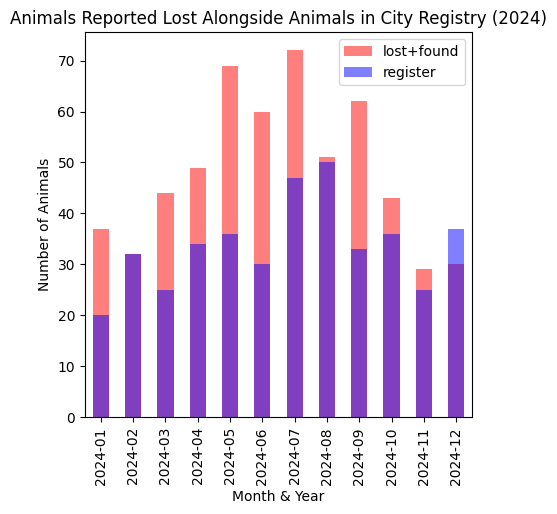

In [983]:
title = "Animals Reported Lost Alongside Animals in City Registry (2024)"
xlabel = "Month & Year"
ylabel = "Number of Animals"
bar_graph(lf_2024, reg_2024, title, xlabel, ylabel)

In 2024, more animals were reported as lost than those that were registered by the City of Vancouver, except for in December. What about in 2025?

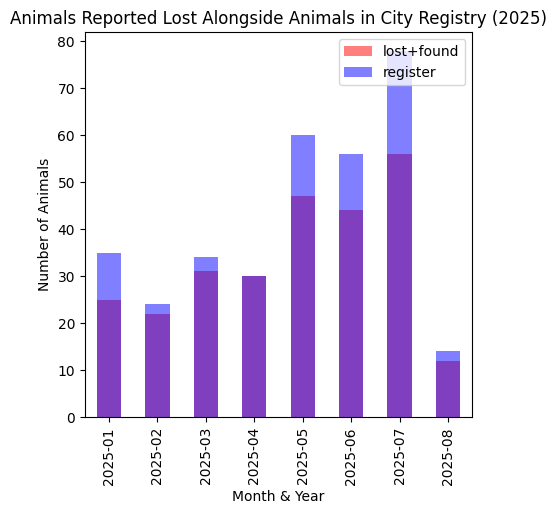

In [984]:
lf_2025, reg_2025 = get_year_count('2025')
bar_graph(reg_2025, lf_2025, "Animals Reported Lost Alongside Animals in City Registry (2025)", xlabel, ylabel);

For 2025, so far at least, it appears that the inverse is true.

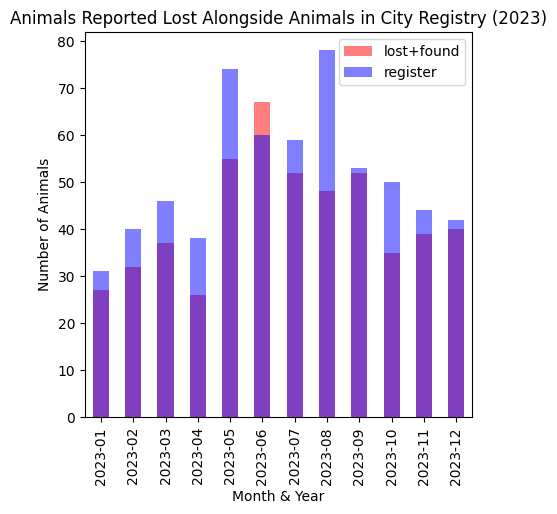

In [985]:
lf_2023, reg_2023 = get_year_count('2023')
bar_graph(reg_2023, lf_2023, "Animals Reported Lost Alongside Animals in City Registry (2023)", xlabel, ylabel);

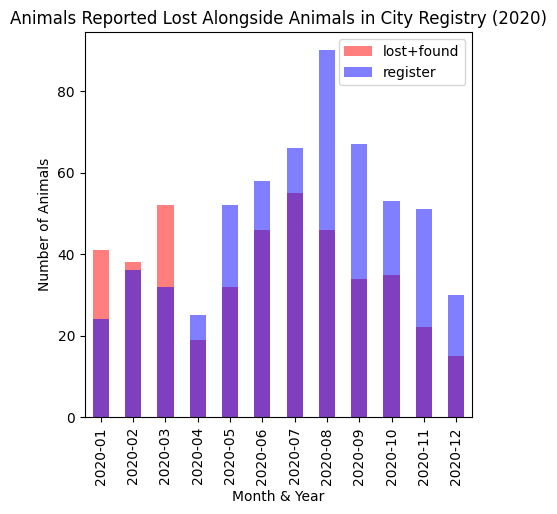

In [986]:
lf_2020, reg_2020 = get_year_count('2020')
bar_graph(reg_2020, lf_2020, "Animals Reported Lost Alongside Animals in City Registry (2020)", xlabel, ylabel);

What about over the past nearly 5 years?

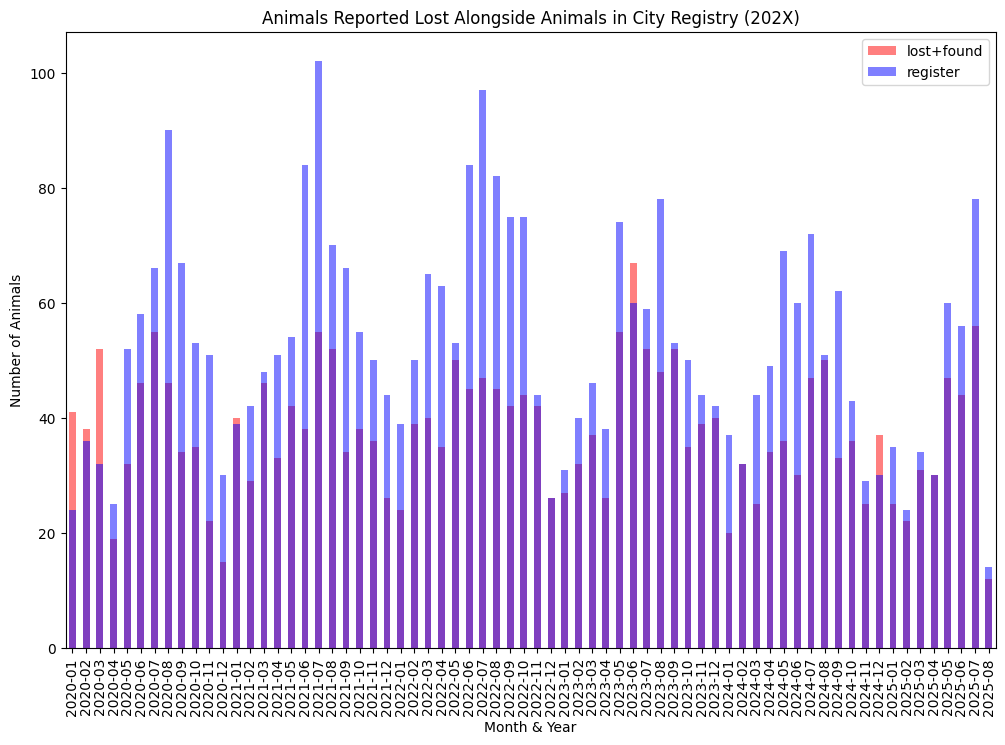

In [987]:
lf_202X, reg_202X = get_year_count('202')
bar = bar_graph(reg_202X, lf_202X, "Animals Reported Lost Alongside Animals in City Registry (202X)", xlabel, ylabel, (12,8));

*Answer to research question:* This helps us answer our research question in a few ways. First, it shows a relationship between the number of animals reported as lost compared to the number of animals brought into the shelter. Generally, the number registered per month exceeds the number of lost animals. This disparity gives me somewhat low confidence in using this method solely for tracking down known lost and sheltered, but unclaimed animals.

#### Visual 2: Animal State Pie Chart

My next concern is how many animals are not yet tracked as "matched" or "found" in the system? How does this compare to the entire dataset?

We'll be using the merged dataset created earlier and stored in `lf_reg_merged`. As a reminder, here is what that merged data looks like:

In [988]:
lf_reg_merged.head()

,date,breed,color_x,sex,state,name,shortdate,receiptnumber,dateimpounded,dispositiondate,color_y,approxweight,agecategory,source,status
0,1999-01-04,shep mix,"[black, tan]",f,found,unknown,1999-01,20043,1999-01-21,unknown,"[blk, tan]",unknown,unknown,unknown,redeemed
1,1999-01-04,shep mix,"[black, tan]",f,found,unknown,1999-01,20032,1999-01-29,unknown,"[blk, tan]",unknown,unknown,unknown,redeemed
2,1999-01-04,shep mix,"[black, tan]",f,found,unknown,1999-01,20002,1999-01-11,unknown,"[tan, blk]",unknown,unknown,unknown,behavior
3,1999-01-26,airedale,"[black, tan curly fur]",f/s,lost,molly,1999-01,20008,1999-01-26,unknown,"[blk, tan]",unknown,unknown,unknown,redeemed
4,1999-02-08,shep mix,"[black, tan]",m,lost,banjo,1999-02,"7640,wrs #5",1999-02-08,unknown,"[grey, black]",unknown,unknown,unknown,redeemed


In [989]:
lf_reg_merged.tail()

,date,breed,color_x,sex,state,name,shortdate,receiptnumber,dateimpounded,dispositiondate,color_y,approxweight,agecategory,source,status
755,2025-06-04,yorkshire terrier,"[brown, beige]",f,matched,chona,2025-06,n/a - rhf - hb,2025-06-04,2025-06-05,"[black, grey, brown]",unknown,adult,holding stray,ride home free
756,2025-06-11,shiba inu,"[brown, cream]",m,matched,kiri,2025-06,n/a - rhf - dc,2025-06-12,2025-06-12,[golden],unknown,young adult,brought-in,ride home free
757,2025-06-22,australian cattle dog mix,"[beige, tan, brown]",f,lost,daisy,2025-06,n/a - medical impound,2025-06-09,2025-06-10,"[beige, tan, brown]",unknown,adult,holding stray,redeemed
758,2025-06-29,french bulldog,"[brown, tan]",f,matched,frankie,2025-06,rhf - nt,2025-06-29,2025-06-29,"[black, cream]",unknown,young adult,brought-in,ride home free
759,2025-07-08,toy poodle,[unknown],f/s,matched,dora,2025-07,di 25-248847 - dc,2025-07-08,2025-07-08,[brown],unknown,young adult,holding stray,redeemed


We can already see that some of the results are quite off while there are some that are likely matches. Before we go too far, lets first visualize the state of each animal. We'll use a pie chart since they are easy to digest and the question we want to answer is somewhat like "how many out of all of the animals are still tracked as lost?"

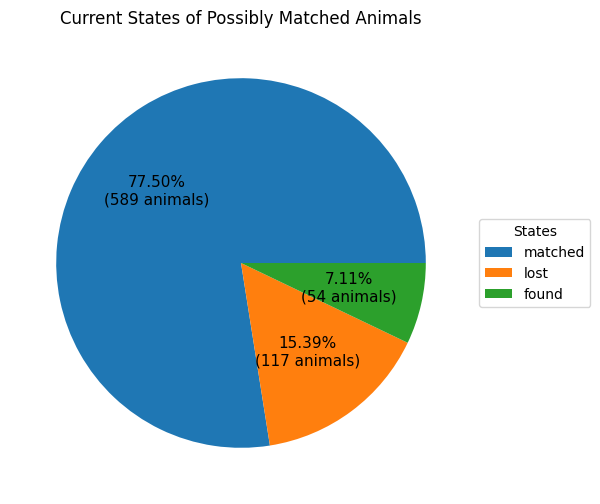

In [990]:
# Heavily assisted/influenced by https://matplotlib.org/stable/gallery/pie_and_polar_charts/pie_and_donut_labels.html

import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(aspect="equal"))

animal_state_counts = lf_reg_merged['state'].value_counts()
animal_counts = animal_state_counts.values
states = animal_state_counts.index


def format_pct(pct, allvals):
    absolute = int(np.round(pct/100.*np.sum(allvals)))
    return f"{pct:.2f}%\n({absolute:d} animals)"


wedges, texts, autotexts = ax.pie(animal_counts, autopct=lambda pct: format_pct(pct, animal_counts),
                                  textprops=dict(color="k"))

ax.legend(wedges, states,
          title="States",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.setp(autotexts, size=11)
ax.set_title("Current States of Possibly Matched Animals")
plt.show()

If a "lost" animal shows up here, that means that they were in custody of the City of Vancouver at some point. Let's now get a query rolling to see what that slice of the pie looks like.

In [991]:
lf_reg_merged.query("state == 'lost'")['status'].value_counts()

status
redeemed                       91
ride home free                 20
passed away                     2
sold                            1
behavior                        1
owner request - signed over     1
transferred                     1
Name: count, dtype: int64

None of those statuses sound like the animal is still in the shelter. Using all of the data, we can see below that there are some states like "viewable", "adoptable" and so on that indicate the animal is likely still in the shelter.

In [992]:
reg_df_clean['status'].value_counts()

status
redeemed                       14109
sold                            5087
ride home free                  4493
transferred                     1502
behavior                         219
health                           198
owner request - signed over      162
passed away                       82
released ( wildlife)              52
court ordered                     41
fostered                          12
impound                           10
escaped                           10
unknown                            9
adoptable                          8
hold                               5
viewable                           4
seized                             4
adoption assessment                3
stolen                             2
adoption pending                   1
Name: count, dtype: int64

*Answer to research question:* Our research question is somewhat answered by this, indicating that there are no animals that are in the shelter, but reported as lost to the City of Vancouver. At least as of Aug 7 2025, these are the results I see:

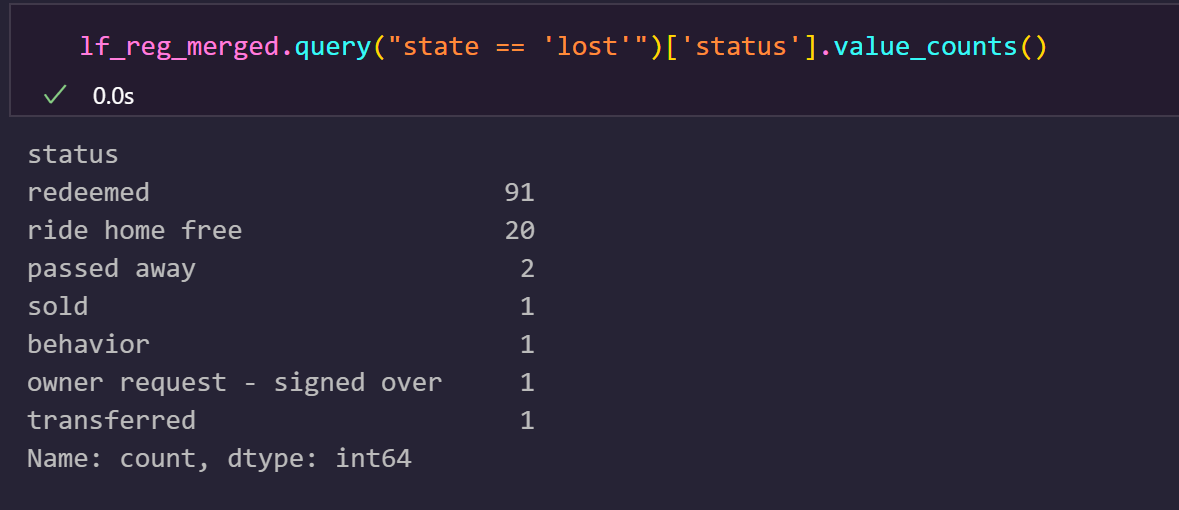

We do need to bear in mind that the system for combining the data, being the merge I did earlier, is certainly not the perfect way to do it. Ideally, we would be doing some fuzzy matching on the breed and name, as any of those things could be misspelled or mistaken. 

With all of that said, there is still more work that can be done with this incredibly interesting dataset, including a lot more cleaning/normalization.